<a href="https://colab.research.google.com/github/sefrancogo/Analitica-de-Datos/blob/master/Covid_Paises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wget 
import pandas as pd
import numpy as np 
import wget 
import matplotlib.pyplot as plt
%matplotlib inline

url = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
#path = 'data/Casos_positivos_de_COVID-19_en_Colombia04_15_2020.csv'

wget.download(url, 'datos_covid_paises.cvs')
data = pd.read_csv('datos_covid_paises.cvs')
data.head()

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=292d5b4d2e4680e54c1facbdf046196725162a59571fa9caabfad0a995ef6bdb
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,22,22,22,24,24,40,40,74,84,94,110,110,120,170,174,237,273,281,299,349,367,423,444,484,521,555,607,665,714,784,840,906,933,996,1026,1092,1176,1279,1351,1463
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,55,59,64,70,76,89,104,123,146,174,186,197,212,223,243,259,277,304,333,361,377,383,400,409,416,433,446,467,475,494,518,539,548,562,584,609,634,663,678,712
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,60,74,87,90,139,201,230,264,302,367,409,454,511,584,716,847,986,1171,1251,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007,3127,3256
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,39,39,53,75,88,113,133,164,188,224,267,308,334,370,376,390,428,439,466,501,525,545,564,583,601,601,638,646,659,673,673,696,704,713,717,717,723,723,731,738
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2,2,3,3,3,4,4,5,7,7,7,8,8,8,10,14,16,17,19,19,19,19,19,19,19,19,19,19,24,24,24,24,25,25,25,25


In [0]:
#funcion ventaneo
def covid_win(serie,w=5):
    pi =0
    pf = w
    X = serie[pi:pf].reshape(1,-1)
    y = serie[pf+1].reshape(1,-1)
    pi += 1
    pf+= 1
    while pf+1 < serie.shape[0]:        
        X = np.append(X,serie[pi:pf].reshape(1,-1),axis=0)
        y = np.append(y,serie[pf+1].reshape(1,-1),axis=0)
        pi += 1
        pf+=1
    return X, y # X \in Real^{N x P = w}, y \in Real^N

In [0]:
#Ubicar Posicion de pais
ii = data[data.columns[1]] == 'Colombia'

#contagios  acumulados
serie = np.array(data.iloc[np.where(ii)[0][0],4:])
#numero contagiados por dia
serie_d = np.append(0,np.diff(serie))
#serie_d = np.append(0,np.cumsum(np.diff(serie)))

X, y = covid_win(serie,w=5)
X_d, y_d = covid_win(serie_d,w=5)

In [4]:
X[-1,:]

array([3792, 3977, 4149, 4356, 4561], dtype=object)

### Analisis Exploratorio PCA

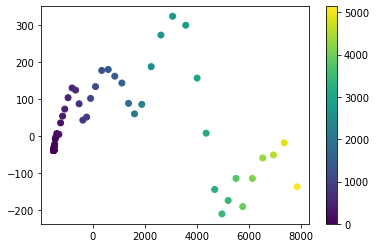

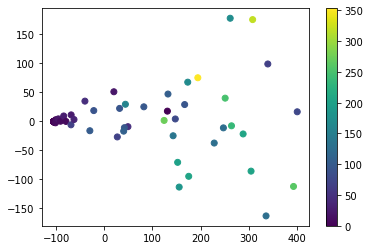

In [6]:
from sklearn.decomposition import PCA

red = PCA()
red_d = PCA()

z = red.fit_transform(X)
z_d = red_d.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()

plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()

### Analisis Exploratorio TSNE

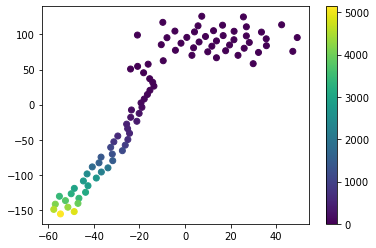

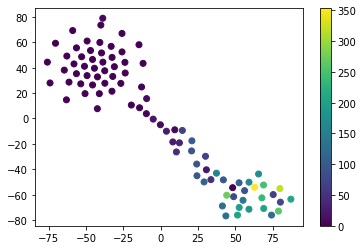

In [7]:
from sklearn.manifold import TSNE

red = TSNE(n_components = 2, perplexity=10)
red_d = TSNE(n_components = 2, perplexity=10)

z = red.fit_transform(X)
z_d = red.fit_transform(X_d)

plt.scatter(z[:,0],z[:,1],c=y)
plt.colorbar()
plt.show()

plt.scatter(z_d[:,0],z_d[:,1],c=y_d)
plt.colorbar()
plt.show()

### Extrer conjunto de Entrenamiento y Prueba
Cuando se tienen pocos datos es necesario realizar una validaación cruzada anidada.

### Validación Cruzada Anidada


In [0]:
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from joblib import dump, load

def V_Cruzada_Anidada(X_data,Y_data,steps,parameters):
  
  Niter = 10                           #numero particiones outter loop nested cross-validation
  msev = np.zeros((Niter,len(steps)))  #arreglo para guardar acierto
  best_estimators = []                 #mejor metodo por iteracion
  ###clave del funcionamiento
  best_hyperpar = []                   #mejor metodo por iteracion 
            

  for j in range(Niter): #outter loop
      print('it %d/%d'%(j+1,Niter))
      #particiono datos outter loop
      X_train, X_test, y_train, y_test = train_test_split(X_data,Y_data,test_size=0.3) # xtrain 60, xtest 26

      for r in range(len(steps)): #recorro todos los posibles modelos a probar en iteracion j del outter loop
          grid_search = GridSearchCV(Pipeline(steps[r]), parameters[r],cv=5,verbose=10,scoring='neg_mean_absolute_error',n_jobs=5) #cv inner loop
          #xtrain gridsearchcv xtrain split en 12 / cv, 60/5 = 12, xtrain 48 datos validar 12
          # cv = N -> leave one out N <30
          
          #generar mejor modelo
          grid_search.fit(X_train,y_train)
          
          #estimar salida conjunto de test
          y_pred = grid_search.best_estimator_.predict(X_test)
          
          #guardar mejor modelo
          best_estimators.append(grid_search.best_estimator_)
          best_hyperpar.append(grid_search.best_params_)

          #guardar acierto
          msev[j,r] = mse(y_test,y_pred)
          #print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r,len(steps)))
          #print(best_hyperpar)
          #print('mse:',msev[j,r])

          savedata = {
            'acc':msev,
            'best_models':best_estimators,
            'best_parameters':best_hyperpar,
              } 
          #dump(savedata,'covid19_1.joblib')

  return best_estimators,best_hyperpar,msev

### Validacion Cruzada Anidada con:

- Representación PCA
- Regresor KernelRifge

In [96]:
steps = [
         [('scaler', StandardScaler()),           #estandarizar cada atriuto columna de xtrain centrada en 0 y var = 1
          ('reg',  KernelRidge(kernel = 'rbf'))],
         [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  KernelRidge(kernel = 'rbf'))]
          ]

parameters = [
                {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__alpha':[1e-3,1e-2,1e-1,1,10,100]
                 },
                {'reg__gamma':[1e-3,1e-2,1e-1,1,10,100],
                 'reg__alpha':[1e-3,1e-2,1e-1,1,10,100],
                 'rep__n_components':[0.5,0.75,0.9]
                 }
               ]

label_model = ['NorSC-KRRBF','NorSC-PCA-KRRBF']

B_Model, B_Hiperpara, MAE = V_Cruzada_Anidada(X,y,steps,parameters)

it 1/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0246s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0290s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0554s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1984s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Do

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1464s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  86 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 166 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 443 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 486 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 514 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 529 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0113s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)

it 2/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0942s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1038s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 129 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0085s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0085s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0687s.) Setting batch_size=8.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1169s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1950s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 364 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 468 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 481 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 494 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 509 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 524 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0055s.) Setting batch_size=

it 3/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0430s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  29 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  58 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1229s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0150s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0663s.) Setting batch_size=4.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0946s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1545s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1634s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 446 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 490 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 503 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 518 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0065s.

it 4/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0676s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 119 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 142 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 153 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 164 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0126s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0126s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0836s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1593s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1799s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 364 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 406 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 481 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 494 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 509 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 524 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.8s finished
[Parallel(n

it 5/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0601s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 127 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 165 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0064s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0064s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0592s.) Setting batch_size=8.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0675s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 194 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 338 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 469 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0160s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0160s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0490s.) Setting batch_size=8.


it 6/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0651s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  98 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 128 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 144 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 155 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 166 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0731s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1537s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1881s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 194 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 324 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 377 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 452 tasks   

it 7/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0868s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 141 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 163 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0096s.) Setting batch_size=2.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0447s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0987s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1286s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]:

it 8/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1160s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 118 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 134 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 163 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0082s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0082s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0655s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1457s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1871s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 333 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 406 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 450 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 494 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 509 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 524 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.7s finished
[Parallel(n

it 9/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0755s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0087s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0087s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0844s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0895s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1987s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 364 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 375 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 481 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 494 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 509 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 524 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent worker

it 10/10
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1488s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 122 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 147 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0149s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0149s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1162s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1889s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 102 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 174 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 334 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 450 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 493 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    1.7s finished


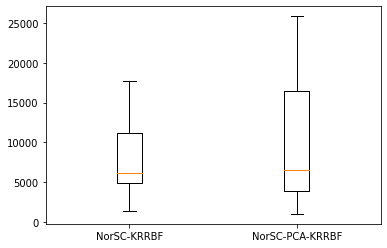

In [98]:
plt.boxplot(MAE)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model)
plt.show()

In [97]:
MAE

array([[ 2411.30743339,  1113.41319496],
       [ 6679.85563758,  5080.72917493],
       [ 4666.47963015, 18215.34008179],
       [11466.84014697, 11404.93314964],
       [15723.41008048, 22954.08213993],
       [17731.17153681, 25839.40788489],
       [ 5662.08140199,  3800.46087151],
       [10308.15155229,  7876.0076297 ],
       [ 5544.50314763,  4410.39984803],
       [ 1404.19421049,  1021.69447203]])

In [99]:
B_Model[11]

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)

In [100]:
B_Hiperpara[11]

{'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}

In [0]:
steps =  [('scaler', StandardScaler()),
          ('rep', PCA()),                         
          ('reg',  KernelRidge(kernel = 'rbf'))]

param = {'reg__alpha': [0.001], 'reg__gamma': [0.1], 'rep__n_components': [0.9]}

pipeline = Pipeline(steps = steps)
grid_search = GridSearchCV(pipeline, param, n_jobs=4,cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train,y_train)
Best_Model = grid_search.best_estimator_          

In [105]:
Xn = X[-1]
Xn = Xn.reshape(1,-1)
Pre_abr25 = Best_Model.predict(Xn)

print('Número de contagiados en los últimos 5 días:',Xn)
print('Predicción de contagios siguiente día:',Pre_abr25)

Número de contagiados en los últimos 5 días: [[3792 3977 4149 4356 4561]]
Predicción de contagios siguiente día: [[5122.82324312]]
